# Import Libraries

In [1]:
import numpy as np
import torch

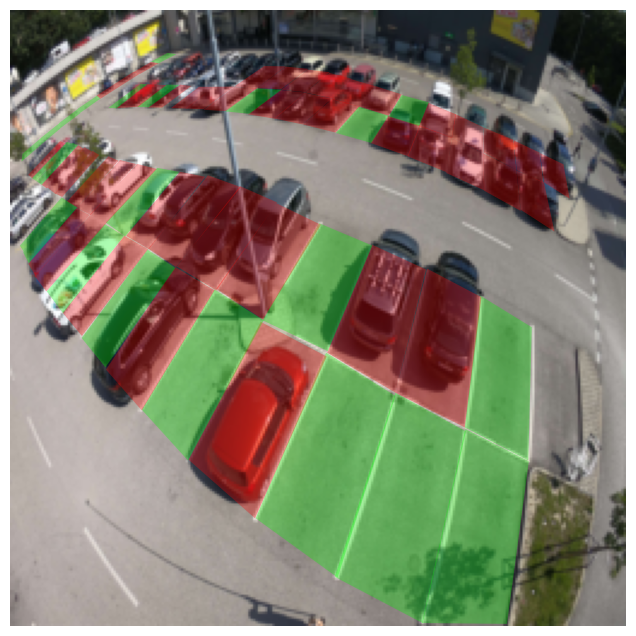

In [11]:
from data import acpds
from utils import visualize as vs
from utils import transform as tf

train_ds, valid_ds, test_ds = acpds.create_datasets('datasets/parking_rois_gopro')
image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = tf.preprocess(image_raw, res=(256, 256))
vs.plot_ds_image(image, rois, labels, show=True)